# iml Tutorial: Interpreting black box machine learning models

In this tutorial you will learn interactively how to make black box machine learning models interpretable using the iml package

Machine learning models usually perform really well for predictions, but are not interpretable.
The iml package provides tools for analysing any black box machine learning model:

* Feature importance: Which were the most important features?

* Feature effects: How does a feature influence the prediction? (Partial dependence plots and individual conditional expectation curves)

* Explanations for single predictions: How did the feature values of a single data point affect its prediction?  (LIME and Shapley value)

* Surrogate trees: Can we approximate the underlying black box model with a short decision tree?

* The iml package works for any classification and regression machine learning model: random forests, linear models, neural networks, xgboost, etc.

This document shows you how to use the iml package to analyse machine learning models. 

If you want to learn more about the technical details of all the methods, read chapters from: https://christophm.github.io/interpretable-ml-book/agnostic.html


In [1]:
# Loading the packages
library(iml)
# We use the mlr package for training the machine learning models
library(mlr)

Loading required package: ParamHelpers
Warning message:
“replacing previous import ‘BBmisc::isFALSE’ by ‘backports::isFALSE’ when loading ‘mlr’”

In [2]:
set.seed(1014)

We'll use the `MASS::Boston` dataset to demonstrate the abilities of the iml package. This dataset contains median house values from Boston neighbourhoods. 

In [3]:
data("Boston", package  = "MASS")
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


First we train a randomForest to predict the Boston median housing value:


In [4]:
data("Boston", package  = "MASS")
lrn = makeLearner("regr.randomForest", ntree = 50)
task = makeRegrTask(data = Boston, target = "medv")
rf = train(learner = lrn, task = task)

We create a `Predictor` object, that holds the model and the data. The iml package uses R6 classes: New objects can be created by calling `Predictor$new()`.

In [5]:
X = Boston[which(names(Boston) != "medv")]
predictor = Predictor$new(rf, data = X, y = Boston$medv)

## Feature importance

We can measure how important each feature was for the predictions with `FeatureImp`. The feature importance measure works by shuffling each feature and measuring how much the performance drops. For this regression task we choose to measure the loss in performance with the mean absolute error ('mae'), another choice would be the  mean squared error ('mse').


Once we create a new object of `FeatureImp`, the importance is automatically computed. 
We can call the `plot()` function of the object or look at the results in a data.frame.

Warning message in predict.WrappedModel(model, newdata = newdata):
“Provided data for prediction is not a pure data.frame but from class data.table, hence it will be converted.”

feature,original.error,permutation.error,importance
lstat,0.9744517,4.205531,4.315792
rm,0.9744517,3.700886,3.797916
crim,0.9744517,1.822796,1.870587
ptratio,0.9744517,1.636104,1.679000
nox,0.9744517,1.606949,1.649080
dis,0.9744517,1.595513,1.637344
indus,0.9744517,1.545451,1.585970
age,0.9744517,1.414705,1.451796
tax,0.9744517,1.331467,1.366376
black,0.9744517,1.239548,1.272047


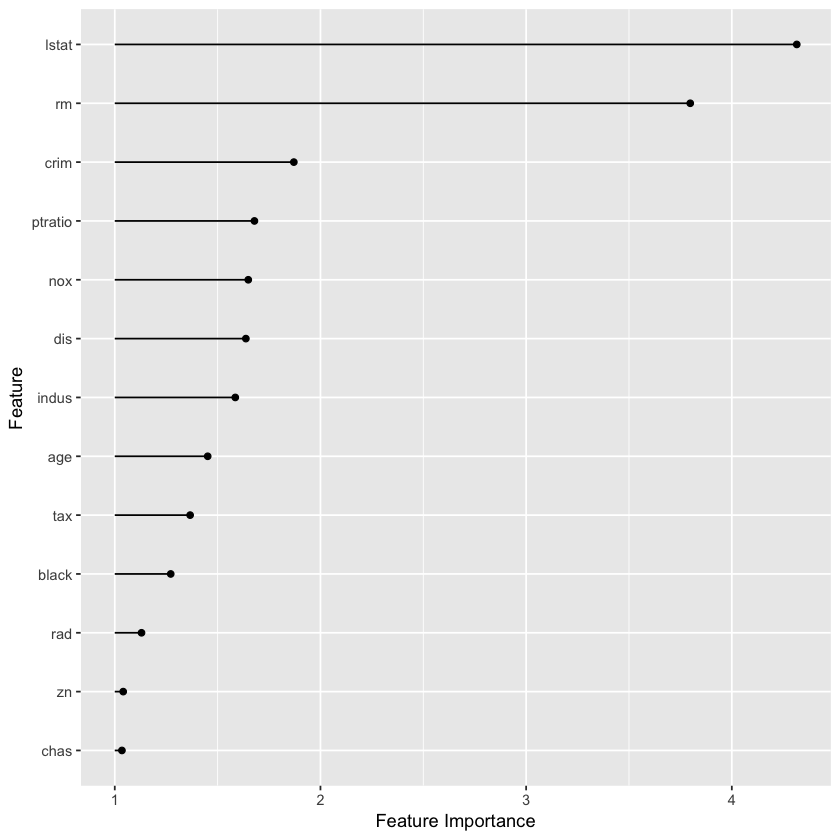

In [6]:
imp = FeatureImp$new(predictor, loss = "mae")
plot(imp)
imp$results

## Partial dependence

Besides knowing which features were important, we are interested in how the features influence the predicted outcome. The `Partial` class implements partial dependence plots and individual conditional expectation curves. Each individual line represents the predictions (y-axis) for one data point when we change one of the features (e.g. 'lstat' on the x-axis). The highlighted line is the point-wise average of the individual lines and equals the partial dependence plot. The marks on the x-axis indicates the distribution of the 'lstat' feature, showing how relevant a region is for interpretation (little or no points mean that we should not over-interpret this region).


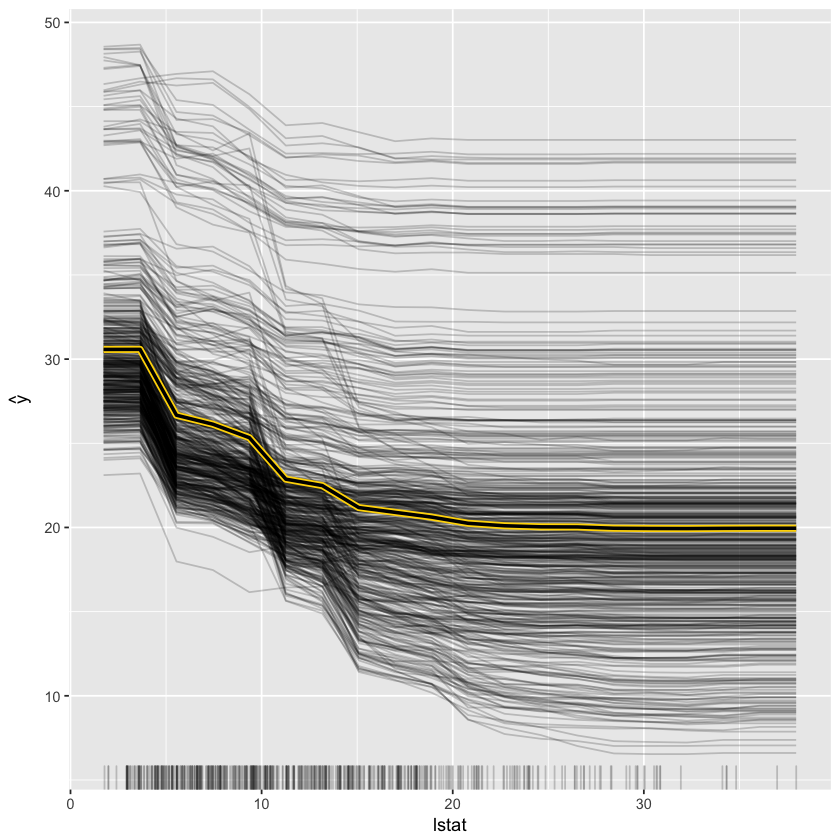

In [7]:
pdp.obj = Partial$new(predictor, feature = "lstat")
pdp.obj$plot()

If we want to compute the partial dependence curves on another feature, we can simply reset the feature:

Interpretation method:  Partial 
features: rm[numerical]
grid size: 20

Analysed predictor: 
Prediction task: regression 


Analysed data:
Sampling from data.frame with 506 rows and 13 columns.

Head of results:
        rm  ..y.hat ..type ..id
1 3.561000 20.25812    pdp   NA
2 3.835684 20.25812    pdp   NA
3 4.110368 20.22767    pdp   NA
4 4.385053 20.15365    pdp   NA
5 4.659737 20.10260    pdp   NA
6 4.934421 20.09119    pdp   NA

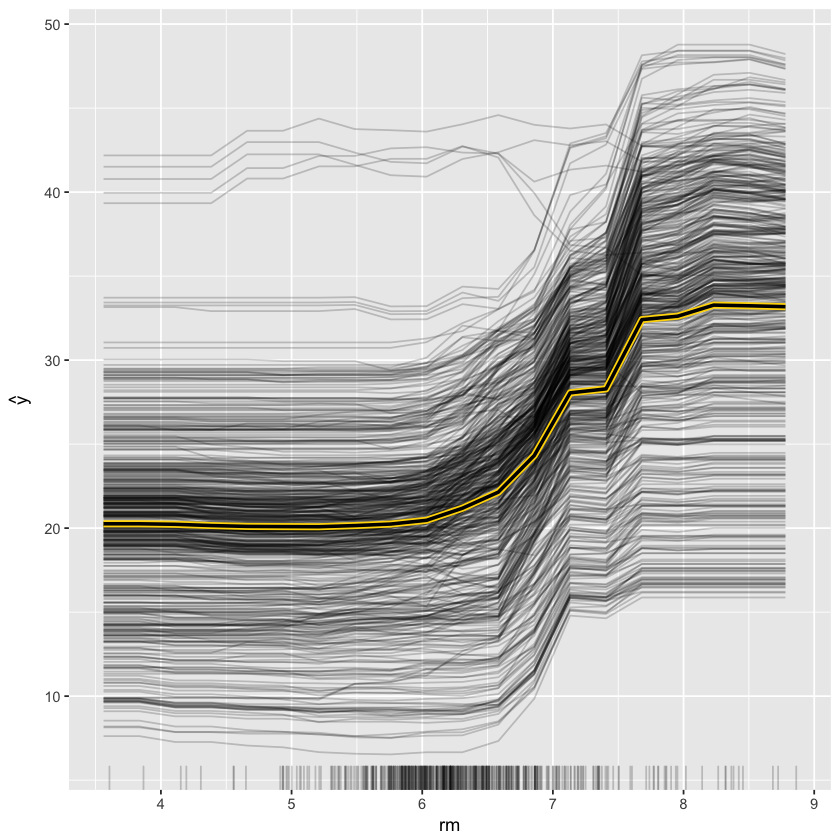

In [8]:
pdp.obj$set.feature("rm")
pdp.obj$plot()

We can center the curves at a feature value of our choice, which makes it easier to see the trend of the curves:


Interpretation method:  Partial 
features: rm[numerical]
grid size: 20

Analysed predictor: 
Prediction task: regression 


Analysed data:
Sampling from data.frame with 506 rows and 13 columns.

Head of results:
        rm     ..y.hat ..type ..id
1 3.561000  0.00000000    pdp   NA
2 3.835684  0.00000000    pdp   NA
3 4.110368 -0.03045369    pdp   NA
4 4.385053 -0.10447003    pdp   NA
5 4.659737 -0.15551864    pdp   NA
6 4.934421 -0.16693557    pdp   NA

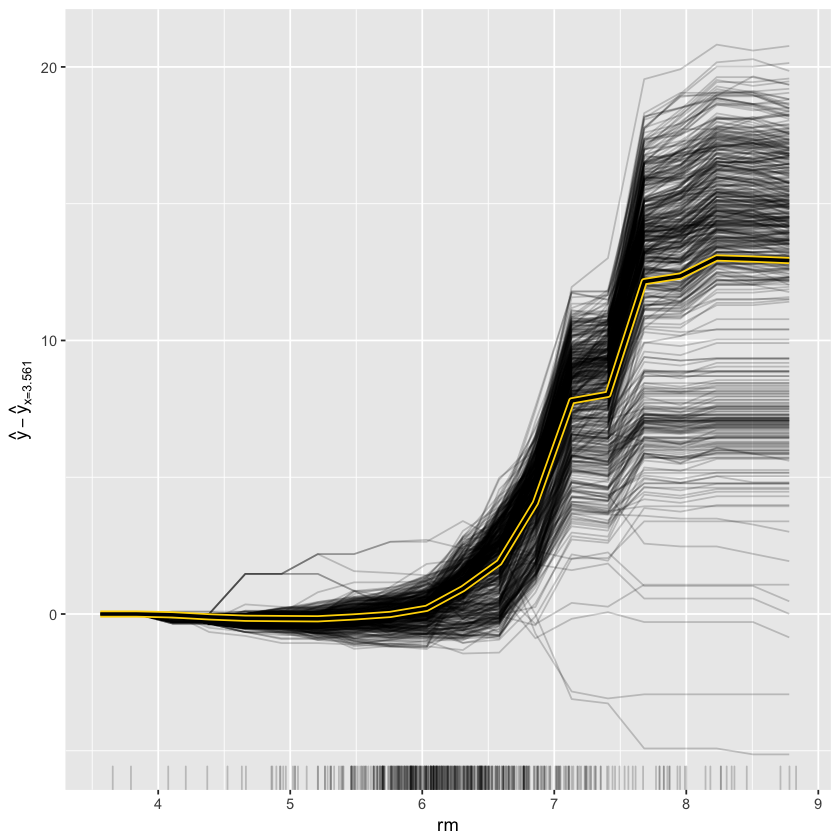

In [9]:
pdp.obj$center(min(Boston$rm))
pdp.obj$plot()

## Surrogate model
Another way to make the models more interpretable is to replace the black box with a simpler model - a decision tree. We take the predictions of the black box model (in our case the random forest) and train a decision tree on the original features and the predicted outcome. 
The plot shows the terminal nodes of the fitted tree.
The maxdepth parameter controls how deep the tree can grow and therefore how interpretable it is.


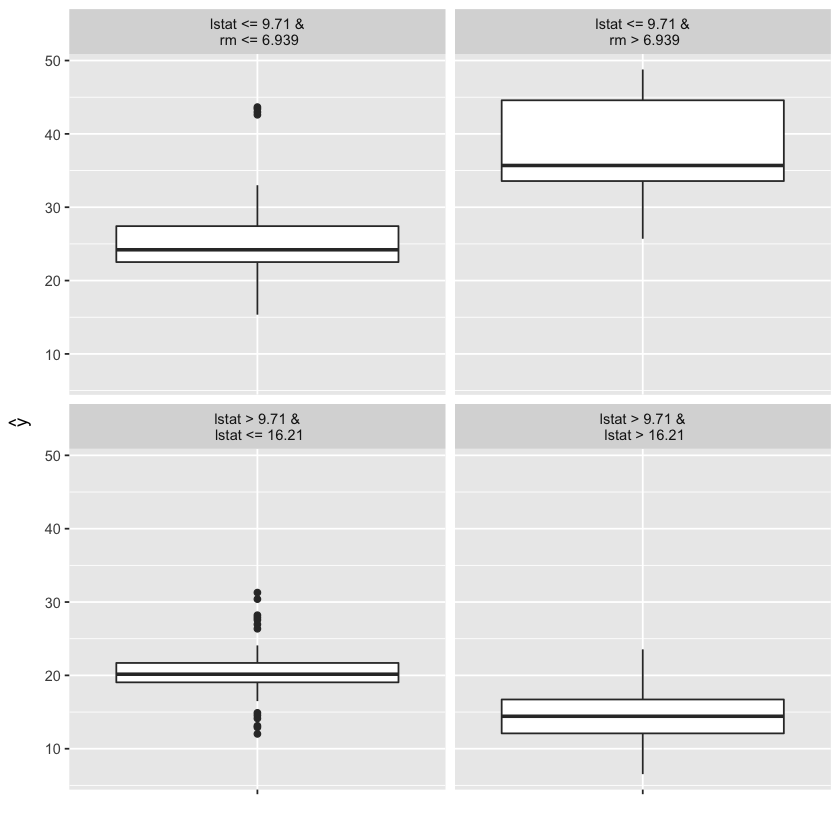

In [10]:
tree = TreeSurrogate$new(predictor, maxdepth = 2)
plot(tree)

We can use the tree to make predictions:


In [11]:
head(tree$predict(Boston))

..y.hat
25.24917
25.24917
38.05587
38.05587
38.05587
25.24917


## Explain single predictions with a local model
Global surrogate model can improve the understanding of the global model behaviour. 
We can also fit a model locally to understand an individual prediction better. The local model fitted by `LocalModel` is a linear regression model and the data points are weighted by how close they are to the data point for wich we want to explain the prediction.


Loading required package: glmnet
Warning message:
“package ‘glmnet’ was built under R version 3.4.4”Loading required package: Matrix
Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.4.3”Loaded glmnet 2.0-16

Loading required package: gower


,beta,x.recoded,effect,x.original,feature,feature.value
rm,4.5162358,6.575,29.694251,6.575,rm,rm=6.575
ptratio,-0.5418047,15.300,-8.289611,15.3,ptratio,ptratio=15.3
lstat,-0.4245632,4.980,-2.114325,4.98,lstat,lstat=4.98


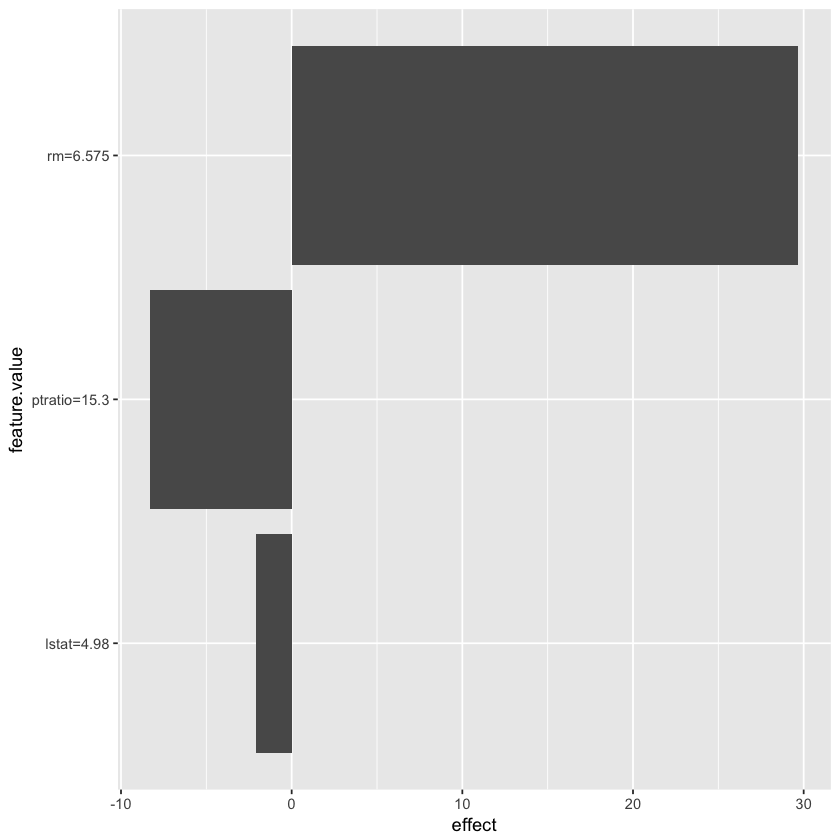

In [12]:
lime.explain = LocalModel$new(predictor, x.interest = X[1,])
lime.explain$results
plot(lime.explain)

Interpretation method:  LocalModel 


Analysed predictor: 
Prediction task: regression 


Analysed data:
Sampling from data.frame with 506 rows and 13 columns.

Head of results:
              beta x.recoded    effect x.original feature feature.value
rm       4.2803915     6.421 27.484394      6.421      rm      rm=6.421
ptratio -0.5195805    17.800 -9.248533       17.8 ptratio  ptratio=17.8
lstat   -0.4245834     9.140 -3.880693       9.14   lstat    lstat=9.14

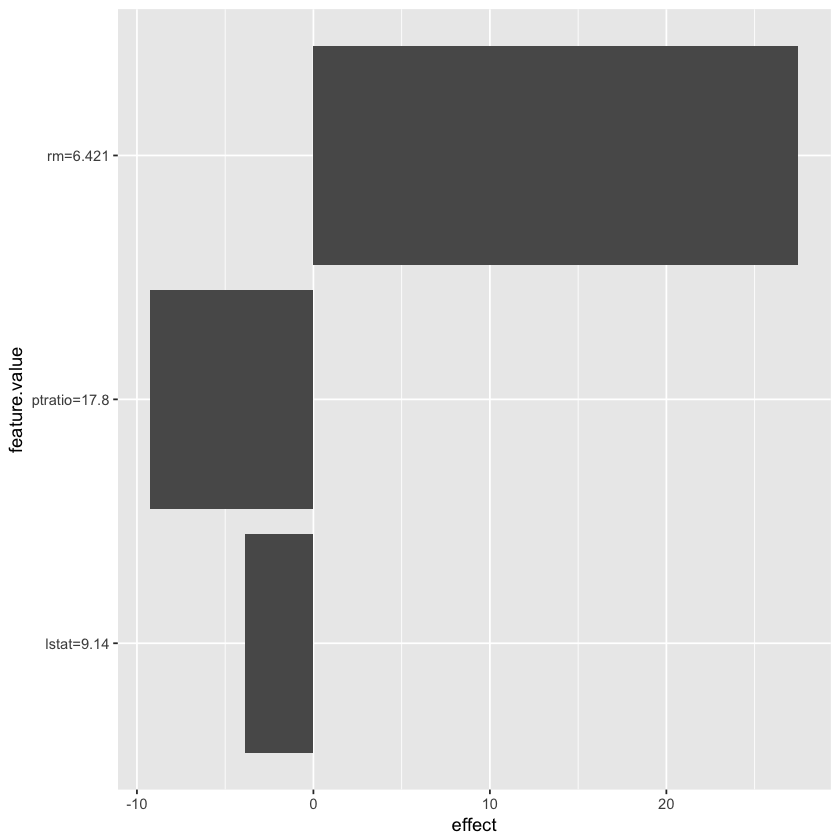

In [13]:
lime.explain$explain(X[2,])
plot(lime.explain)


## Explain single predictions with game theory
An alternative for explaining individual predictions is a method from coalitional game theory named Shapley value.
Assume that for one data point, the feature values play a game together, in which they get the prediction as a payout. The Shapley value tells us how to fairly distribute the payout among the feature values.


Warning message in predict.WrappedModel(model, newdata = newdata):
“Provided data for prediction is not a pure data.frame but from class data.table, hence it will be converted.”

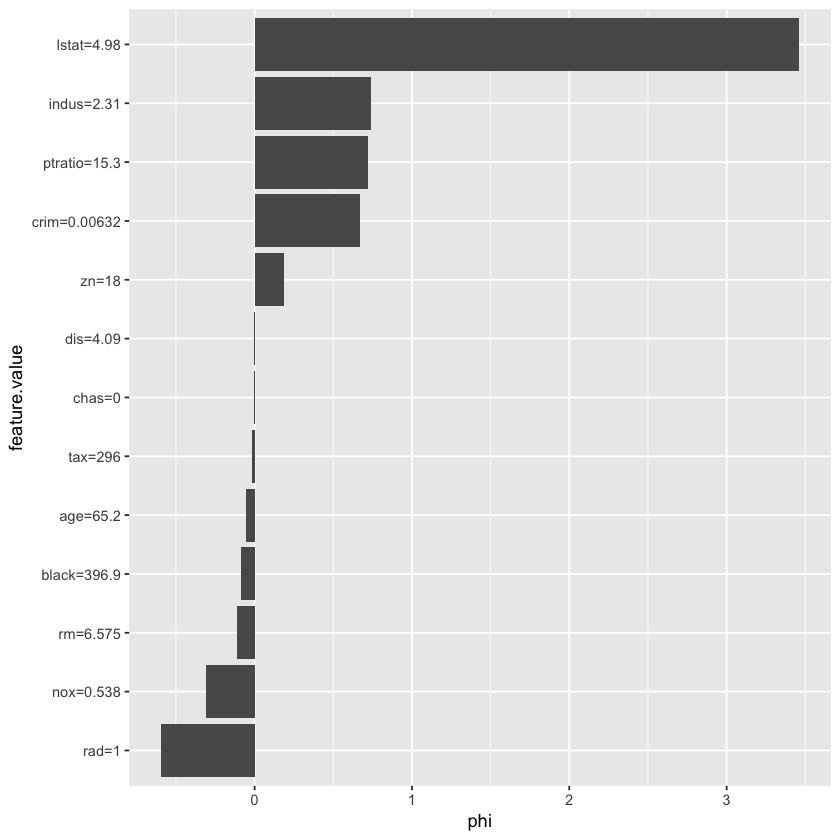

In [14]:
shapley = Shapley$new(predictor, x.interest = X[1,])
shapley$plot()

Re-use the object to explain other data points:


Warning message in predict.WrappedModel(model, newdata = newdata):
“Provided data for prediction is not a pure data.frame but from class data.table, hence it will be converted.”

Interpretation method:  Shapley 
Predicted value: 22.447800, Average prediction: 22.558984 (diff = -0.111184)

Analysed predictor: 
Prediction task: regression 


Analysed data:
Sampling from data.frame with 506 rows and 13 columns.

Head of results:
  feature         phi     phi.var feature.value
1    crim -0.22736690  3.07947084  crim=0.02731
2      zn -0.02547100  0.01596178          zn=0
3   indus -0.48752980  1.27280565    indus=7.07
4    chas -0.07965367  0.08869790        chas=0
5     nox  0.19162545  1.17416760     nox=0.469
6      rm -1.73640776 23.69811146      rm=6.421

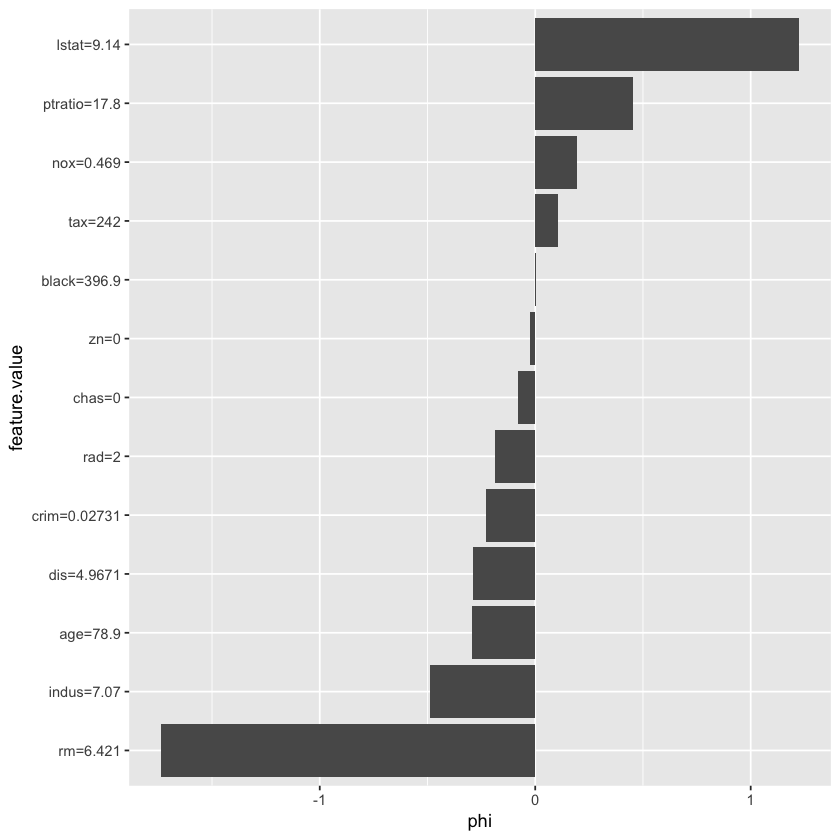

In [15]:
shapley$explain(x.interest = X[2,])
shapley$plot()

The results in data.frame form can be extracted like this:


In [16]:

results = shapley$results
head(results)


feature,phi,phi.var,feature.value
crim,-0.22736690,3.07947084,crim=0.02731
zn,-0.02547100,0.01596178,zn=0
indus,-0.48752980,1.27280565,indus=7.07
chas,-0.07965367,0.08869790,chas=0
nox,0.19162545,1.17416760,nox=0.469
rm,-1.73640776,23.69811146,rm=6.421
